In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pandas as pd

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec

import w2v_utils
import enrichr
import evaluations

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

# Load trained w2v model

In [3]:
model = Word2Vec.load('../data/models/word2vec-3000000-docs-100-dims.model') 

In [4]:
wv_mat, vocab_df = w2v_utils.parse_model(model)
print(wv_mat.shape, vocab_df.shape)

(23569, 3)
(20069, 2)
(180954, 100) (180954, 5)


In [5]:
vocab_df.head()

index       token gene     count        word
0      0   searching  NaN      5110   searching
1      1   biomarker  NaN     51147   biomarker
2      2  candidates  NaN     24592  candidates
3      3          in  NaN  21943868          in
4      4       serum  NaN    576918       serum

In [6]:
gene_vec_df = w2v_utils.get_gene_vec_df(wv_mat, vocab_df)

(15090,)
(15090, 100)
(14943, 100)


# Load Enrichr libs of interest

In [7]:
lib_names = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015', 'ENCODE_Histone_Modifications_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEGG_2016', 'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'
            ]
# Parse all gmts 
d_gmt = {}
for lib_name in lib_names:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 50825


In [8]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes_enrichr = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
tf_mat.shape

(50825, 63178)

In [9]:
# Filter out rare genes
cutoff = 10
mask = np.asarray(tf_mat.sum(axis=0)).reshape(-1) > cutoff
tf_mat = tf_mat[:, mask]
genes_enrichr = genes_enrichr[mask]
print(tf_mat.shape, genes_enrichr.shape)

(50825, 32309) (32309,)


In [10]:
# TF-IDF normalization
tfidf = TfidfTransformer(norm='l2')
tfidf_mat = tfidf.fit_transform(tf_mat)
tfidf_mat.shape

(50825, 32309)

In [11]:
# Create a df for terms in gmt
terms_df = pd.DataFrame({
    'library': [ s.split('$')[0] for s in d_gmt.keys()],
    'term': [ s.split('$')[1] for s in d_gmt.keys()],
    'n_genes': [len(val) for val in d_gmt.values()]
}, index=list(d_gmt.keys()))
print(terms_df.shape)

(50825, 3)


In [12]:
# lib used for topic modeling
# libs_x = ['ChEA_2016', 'ENCODE_TF_ChIP-seq_2015']
libs_x = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'    
]

mask_lib_x = np.in1d(terms_df['library'], libs_x)
tf_mat_x = tf_mat[mask_lib_x]
tfidf_mat_x = tfidf_mat[mask_lib_x]
print(tf_mat_x.shape, tfidf_mat_x.shape)

(48969, 32309) (48969, 32309)


In [13]:
# Fit LDA, NMF, LSA models
n_topics = 100
# lda = decomposition.LatentDirichletAllocation(n_components=n_topics, 
#                                               n_jobs=10,
#                                               random_state=2018)
# lda.fit(tf_mat_x)
# X_topics_lda = pd.DataFrame(lda.components_.T, index=genes_enrichr) # genes by topics matrix
# print(X_topics_lda.shape)

In [14]:
# nmf = decomposition.NMF(n_components=n_topics, 
#                         alpha=.1, 
#                         l1_ratio=.5,
#                         random_state=2018,)
# nmf.fit(tfidf_mat_x)
# X_topics_nmf = pd.DataFrame(nmf.components_.T, index=genes_enrichr) # genes by topics matrix
# print(X_topics_nmf.shape)

In [15]:
# svd = decomposition.TruncatedSVD(n_components=n_topics,
#                                 random_state=2018)
# svd.fit(tfidf_mat_x)
# X_topics_svd = pd.DataFrame(svd.components_.T, index=genes_enrichr) # genes by topics matrix
# print(X_topics_svd.shape)

In [16]:
from joblib import load, dump

In [17]:
# dump(lda, '../data/models/LDA-on-ChIP-GMTs.joblib')
# dump(nmf, '../data/models/NMF-on-ChIP-GMTs.joblib')
# dump(svd, '../data/models/SVD-on-ChIP-GMTs.joblib')

In [18]:
# lda = load('../data/models/LDA-on-ChIP-GMTs.joblib')
lda = load('../data/models/LDA-on-14-GMTs.joblib')
X_topics_lda = pd.DataFrame(lda.components_.T, index=genes_enrichr) # genes by topics matrix
print(X_topics_lda.shape)

# nmf = load('../data/models/NMF-on-ChIP-GMTs.joblib')
nmf = load('../data/models/NMF-on-14-GMTs.joblib')
X_topics_nmf = pd.DataFrame(nmf.components_.T, index=genes_enrichr) # genes by topics matrix
print(X_topics_nmf.shape)

# svd = load('../data/models/SVD-on-ChIP-GMTs.joblib')
svd = load('../data/models/SVD-on-14-GMTs.joblib')
X_topics_svd = pd.DataFrame(svd.components_.T, index=genes_enrichr) # genes by topics matrix
print(X_topics_svd.shape)

(32309, 100)
(32309, 100)
(32309, 100)


In [19]:
sys.path.append('/Users/maayanlab/Documents/GitHub/tensorflow-playground/')
from nvdm import NVDM

In [20]:
import scipy.sparse as sp

In [21]:
nvdm10 = NVDM.load('../data/models/NVDM-10epochs-on-14-GMTs/')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../data/models/NVDM-10epochs-on-14-GMTs/model.ckpt


In [22]:
nvdm20 = NVDM.load('../data/models/NVDM-20epochs-on-14-GMTs/')

INFO:tensorflow:Restoring parameters from ../data/models/NVDM-20epochs-on-14-GMTs/model.ckpt


In [23]:
X_topics_nvdm10 = pd.DataFrame(nvdm10.get_topics().T, index=genes_enrichr)
X_topics_nvdm10.shape

(32309, 100)

In [24]:
X_topics_nvdm20 = pd.DataFrame(nvdm20.get_topics().T, index=genes_enrichr)
X_topics_nvdm20.shape

(32309, 100)

In [25]:
# Convert the filtered tf_mat to a DataFrame for finding and ordering by shared genes
tf_mat_df = pd.DataFrame(tf_mat.transpose().toarray(), index=genes_enrichr)
tf_mat_df.shape

(32309, 50825)

# Load models trained on ARCHS4 data

In [26]:
import h5py

In [27]:
file = h5py.File('../data/archs4/human_matrix.h5', 'r')
genes_archs4 = file['meta']['genes'][:].astype(np.str)
print(genes_archs4.shape)

(35238,)


In [28]:
nmf_archs4 = load('../data/models/NMF-on-archs4.joblib')
X_topics_nmf_archs4 = pd.DataFrame(nmf_archs4.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_nmf_archs4.shape)

(35238, 100)


In [29]:
lda_archs4 = load('../data/models/LDA-on-archs4.joblib')
X_topics_lda_archs4 = pd.DataFrame(lda_archs4.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_lda_archs4.shape)

(35238, 100)


In [30]:
svd_archs4 = load('../data/models/SVD-on_archs4.joblib')
X_topics_svd_archs4 = pd.DataFrame(svd_archs4.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_svd_archs4.shape)

(35238, 100)


# Evaluate

In [31]:
# libs used for evaluation
libs_y = [
    'ENCODE_Histone_Modifications_2015',
    'KEGG_2016',
    'GO_Molecular_Function_2018',
]

In [32]:
from matplotlib_venn import venn3

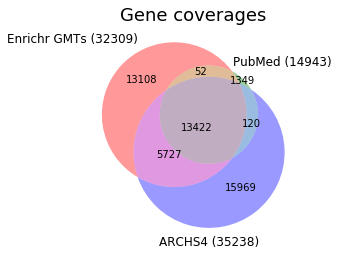

In [33]:
fig, ax = plt.subplots()
venn3([set(tf_mat_df.index), set(gene_vec_df.index), set(genes_archs4)],
      ('Enrichr GMTs (%d)' % len(tf_mat_df.index), 
       'PubMed (%d)' % len(gene_vec_df.index) , 
       'ARCHS4 (%d)' % len(genes_archs4)
      ),
      ax=ax
)
ax.set_title('Gene coverages');

In [34]:
# Find shared genes between gene vectors and Enrichr
shared_genes = list(set(tf_mat_df.index) & set(gene_vec_df.index) & set(genes_archs4))
# shared_genes = list(set(tf_mat_df.index))
len(shared_genes)

13422

In [35]:
tf_mat_df = tf_mat_df.loc[shared_genes].fillna(0)
gene_vec_df = gene_vec_df.loc[shared_genes].fillna(0)
print(tf_mat_df.shape, gene_vec_df.shape)

(13422, 50825) (13422, 100)


In [36]:
X_topics_nmf = X_topics_nmf.loc[shared_genes].fillna(0)
X_topics_lda = X_topics_lda.loc[shared_genes].fillna(0)
X_topics_svd = X_topics_svd.loc[shared_genes].fillna(0)

In [37]:
X_topics_nvdm10 = X_topics_nvdm10.loc[shared_genes].fillna(0)
X_topics_nvdm20 = X_topics_nvdm20.loc[shared_genes].fillna(0)

In [38]:
X_topics_nmf_archs4 = X_topics_nmf_archs4.loc[shared_genes].fillna(0)
X_topics_lda_archs4 = X_topics_lda_archs4.loc[shared_genes].fillna(0)
X_topics_svd_archs4 = X_topics_svd_archs4.loc[shared_genes].fillna(0)

In [39]:
knn_scores = evaluations.NN_generalization_accuracy_wrapper(gene_vec_df.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=True, 
                                               model_name='baseline')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [40]:
knn_scores_g2v = evaluations.NN_generalization_accuracy_wrapper(gene_vec_df.values, libs_y, 
                                                    tf_mat_df.values, 
                                                    terms_df['library'],
                                               dummy=False, 
                                               model_name='gene2vec-PubMed-3M')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [41]:
knn_scores_lda = evaluations.NN_generalization_accuracy_wrapper(X_topics_lda.values, libs_y, 
                                                                tf_mat_df.values, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='LDA-14-GMTs')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [42]:
knn_scores_nmf = evaluations.NN_generalization_accuracy_wrapper(X_topics_nmf.values, libs_y, 
                                                                tf_mat_df.values, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NMF-14-GMTs')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [43]:
knn_scores_svd = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd.values, libs_y, 
                                                                tf_mat_df.values,
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SVD-14-GMTs')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [44]:
knn_scores_nvdm10 = evaluations.NN_generalization_accuracy_wrapper(X_topics_nvdm10.values, libs_y, 
                                                                tf_mat_df.values,
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NVDM10-14-GMTs')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [45]:
knn_scores_nvdm20 = evaluations.NN_generalization_accuracy_wrapper(X_topics_nvdm20.values, libs_y, 
                                                                tf_mat_df.values,
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NVDM20-14-GMTs')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [46]:
knn_scores_lda_archs4 = evaluations.NN_generalization_accuracy_wrapper(X_topics_lda_archs4.values, libs_y, 
                                                                tf_mat_df.values, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='LDA-ARCHS4')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [47]:
knn_scores_nmf_archs4 = evaluations.NN_generalization_accuracy_wrapper(X_topics_nmf_archs4.values, libs_y, 
                                                                tf_mat_df.values, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NMF-ARCHS4')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [48]:
knn_scores_svd_archs4 = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd_archs4.values, libs_y, 
                                                                tf_mat_df.values, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SVD-ARCHS4')

ENCODE_Histone_Modifications_2015 (13422, 412)
KEGG_2016 (13422, 293)
GO_Molecular_Function_2018 (13422, 1151)


In [49]:
knn_scores_all = pd.concat([knn_scores, knn_scores_g2v,
                            knn_scores_lda, 
                            knn_scores_nmf,
                            knn_scores_svd,
                            knn_scores_nvdm10,
                            knn_scores_nvdm20,
                            knn_scores_lda_archs4, 
                            knn_scores_nmf_archs4,
                            knn_scores_svd_archs4,                            
                           ])
knn_scores_all.shape

(150, 3)

## Use only shared genes across the three sources

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


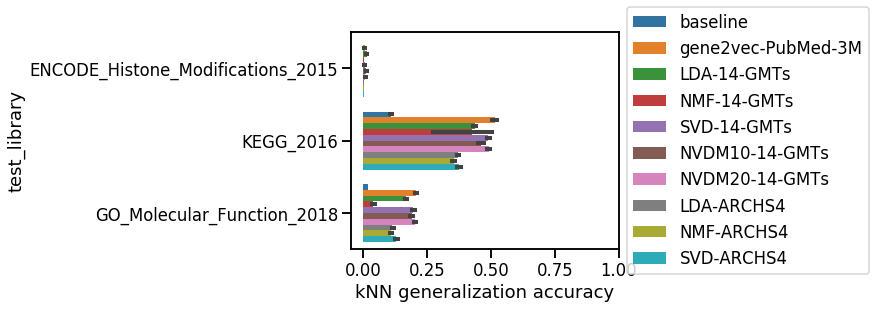

In [50]:
ax = sns.barplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
# ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
ax.set_xlim([-0.05, 1]);

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


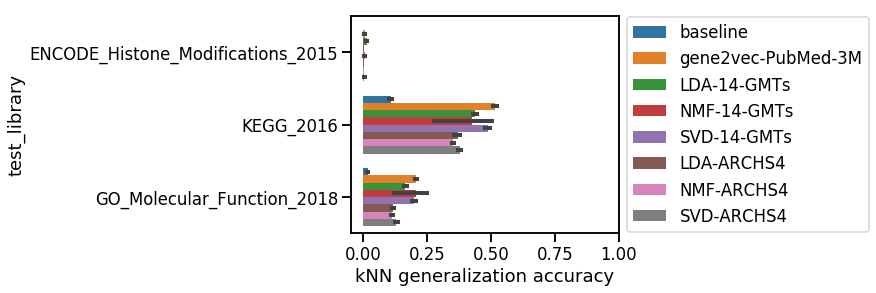

In [39]:
ax = sns.barplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
# ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
ax.set_xlim([-0.05, 1]);

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [50]:
X_topics_lda.shape, tf_mat_df.shape

((13422, 100), (13422, 50825))

In [49]:
pmi_scores_lda = evaluations.topics_coherence_pmis_wrapper(X_topics_lda.values, 
                                               libs_y,
                                               tf_mat_df.values,
                                               terms_df['library'],
                                               model_name='LDA-14-GMTs'
                                              )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [50]:
pmi_scores_nmf = evaluations.topics_coherence_pmis_wrapper(X_topics_nmf.values, 
                                               libs_y,
                                               tf_mat_df.values,
                                               terms_df['library'],
                                               model_name='NMF-14-GMTs'
                                              )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [51]:
pmi_scores_svd = evaluations.topics_coherence_pmis_wrapper(X_topics_svd.values, 
                                               libs_y,
                                               tf_mat_df.values,
                                               terms_df['library'],
                                               model_name='SVD-14-GMTs'
                                              )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [52]:
pmi_scores_nvdm10 = evaluations.topics_coherence_pmis_wrapper(X_topics_nvdm10.values, 
                                               libs_y,
                                               tf_mat_df.values,
                                               terms_df['library'],
                                               model_name='NVDM10-14-GMTs'
                                              )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [53]:
pmi_scores_nvdm20 = evaluations.topics_coherence_pmis_wrapper(X_topics_nvdm20.values, 
                                               libs_y,
                                               tf_mat_df.values,
                                               terms_df['library'],
                                               model_name='NVDM20-14-GMTs'
                                              )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [54]:
gene_vec_df.values.shape, tf_mat_df.values.shape

((13422, 100), (13422, 50825))

In [55]:
pmi_scores_g2v = evaluations.topics_coherence_pmis_wrapper(gene_vec_df.values, 
                                                           libs_y, 
                                                    tf_mat_df.values, 
                                                    terms_df['library'],
                                               model_name='gene2vec-PubMed-3M')

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [56]:
pmi_scores_lda_archs4 = evaluations.topics_coherence_pmis_wrapper(X_topics_lda_archs4.values,
                                                                  libs_y,
                                                                  tf_mat_df.values,
                                                                  terms_df['library'],
                                                                  model_name='LDA-ARCHS4'
                                                                 )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [57]:
pmi_scores_nmf_archs4 = evaluations.topics_coherence_pmis_wrapper(X_topics_nmf_archs4.values,
                                                                  libs_y,
                                                                  tf_mat_df.values,
                                                                  terms_df['library'],
                                                                  model_name='NMF-ARCHS4'
                                                                 )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [58]:
pmi_scores_svd_archs4 = evaluations.topics_coherence_pmis_wrapper(X_topics_svd_archs4.values,
                                                                  libs_y,
                                                                  tf_mat_df.values,
                                                                  terms_df['library'],
                                                                  model_name='SVD-ARCHS4'
                                                                 )

ENCODE_Histone_Modifications_2015 (412, 13422)
KEGG_2016 (293, 13422)
GO_Molecular_Function_2018 (1151, 13422)


In [38]:
pmi_scores_dummy = evaluations.topics_coherence_pmis_wrapper(X_topics_nvdm20.values, 
                                               libs_y,
                                               tf_mat_df.values,
                                               terms_df['library'],
                                                             dummy=True,
                                               model_name='dummy-14-GMTs'
                                              )

ENCODE_Histone_Modifications_2015 (412, 32309)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)


In [59]:
pmi_scores_all = pd.concat([
    pmi_scores_dummy,
    pmi_scores_g2v,
                            pmi_scores_lda, 
                            pmi_scores_nmf,
                            pmi_scores_svd,
                            pmi_scores_nvdm10,
                            pmi_scores_nvdm20,
                            pmi_scores_lda_archs4,
                            pmi_scores_nmf_archs4,
                            pmi_scores_svd_archs4
                           ])
pmi_scores_all.shape

(3000, 3)

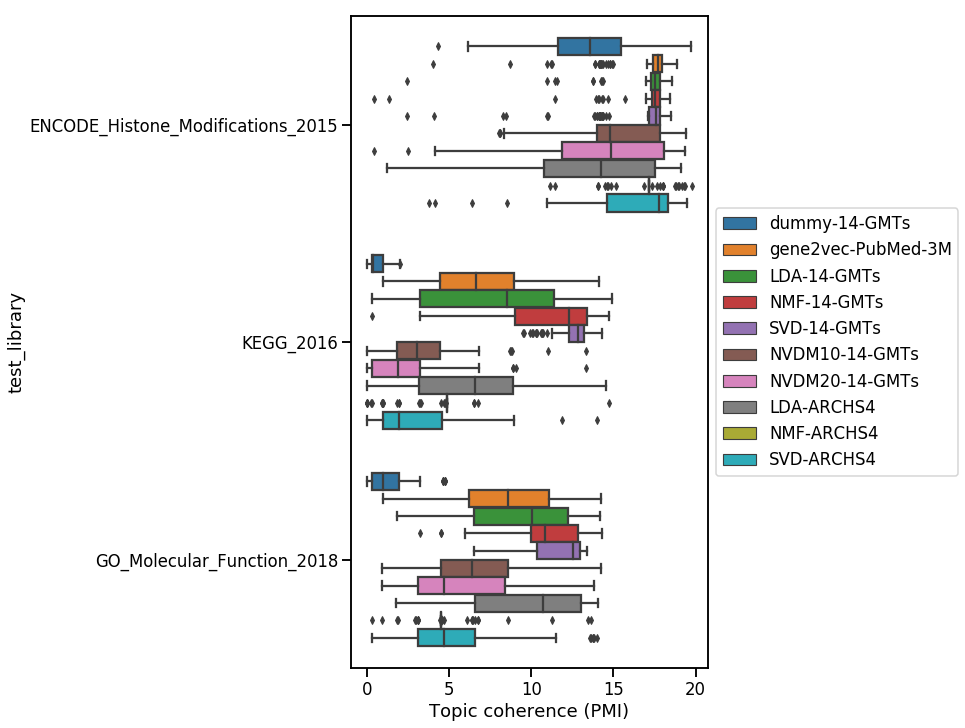

In [60]:
fig, ax = plt.subplots(figsize=(8,12))
# ax = sns.violinplot(y='test_library', x='PMI', data=pmi_scores_all, hue='model', ax=ax)
ax = sns.boxplot(y='test_library', x='PMI', data=pmi_scores_all, hue='model', ax=ax)
ax.set_xlabel('Topic coherence (PMI)')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

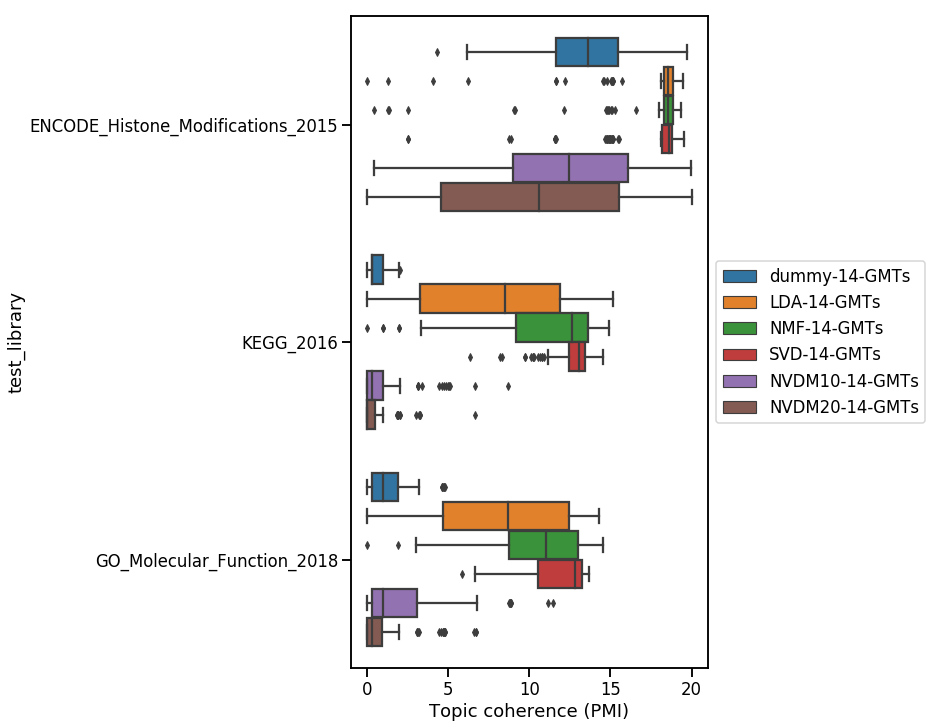

In [40]:
fig, ax = plt.subplots(figsize=(8,12))
# ax = sns.violinplot(y='test_library', x='PMI', data=pmi_scores_all, hue='model', ax=ax)
ax = sns.boxplot(y='test_library', x='PMI', data=pmi_scores_all, hue='model', ax=ax)
ax.set_xlabel('Topic coherence (PMI)')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));